# Let's try to create a Indonesian-English Translator

## Loading libraries and datasets.

In [1]:
import pandas as pd
import numpy as np
import string
import re
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [0]:
data_raw = pd.read_csv('assignment.csv', low_memory=False)

In [3]:
data_raw.head(2)

,unique_id,raw_text,review_text
0,0,Spiritually and mentally inspiring! A book that allows you to question your morals and will help you discover who you really are!,Menginspirasi secara spiritual dan mental! Buku yang memungkinkan Anda mempertanyakan moral Anda dan akan membantu Anda menemukan siapa diri Anda sebenarnya!
1,1,This is one my must have books,Ini adalah salah satu yang harus saya miliki buku


In [4]:
len(data_raw)

53757

## Text Pre-processing

### Text Cleaning

In [0]:
# copying out raw data
data = data_raw.copy()
data['review_text'] = data['review_text'].astype(str)

In [6]:
# Getting rid of punctuations
data['raw_text'] = data['raw_text'].str.translate(str.maketrans('', '', string.punctuation))
data['review_text'] = data['review_text'].str.translate(str.maketrans('', '', string.punctuation))
data.head(2)

,unique_id,raw_text,review_text
0,0,Spiritually and mentally inspiring A book that allows you to question your morals and will help you discover who you really are,Menginspirasi secara spiritual dan mental Buku yang memungkinkan Anda mempertanyakan moral Anda dan akan membantu Anda menemukan siapa diri Anda sebenarnya
1,1,This is one my must have books,Ini adalah salah satu yang harus saya miliki buku


In [7]:
# convert text to lower case
data['raw_text'] = data['raw_text'].str.lower()
data['review_text'] = data['review_text'].str.lower()
data.head(2)

,unique_id,raw_text,review_text
0,0,spiritually and mentally inspiring a book that allows you to question your morals and will help you discover who you really are,menginspirasi secara spiritual dan mental buku yang memungkinkan anda mempertanyakan moral anda dan akan membantu anda menemukan siapa diri anda sebenarnya
1,1,this is one my must have books,ini adalah salah satu yang harus saya miliki buku


### Text to Sequence Conversion
In Seq2Seq model we convert both the input and the output sentences into integer sequences of fixed length.

Visualising the length of the sentences & capturing the lengths of all the sentences in two separate lists for English and Indonesian, respectively.

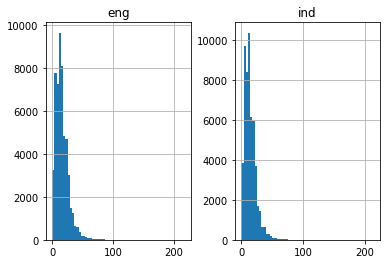

In [8]:
eng_l = []
ind_l = []

for i in data['raw_text']:
  eng_l.append(len(i.split()))

for i in data['review_text']:
  ind_l.append(len(i.split()))

length_df = pd.DataFrame({'eng': eng_l, 'ind': ind_l})

length_df.hist(bins=60)
plt.show()

In [9]:
print('max_eng: ', max(eng_l), 'max_ind: ', max(ind_l))
print('median_eng: ', np.median(eng_l), 'median_ind: ', np.median(ind_l))
print('99percentile_eng: ', np.percentile(eng_l, q=99),
      '99percentile_ind: ', np.percentile(ind_l, q=99))
print('90percentile_eng: ', np.percentile(eng_l, q=90),
      '90percentile_ind: ', np.percentile(ind_l, q=90))

max_eng:  218 max_ind:  215
median_eng:  14.0 median_ind:  12.0
99percentile_eng:  54.0 99percentile_ind:  48.0
90percentile_eng:  29.0 90percentile_ind:  26.0


the maximum length of the Indonesian sentences is 215 and that of the English phrases is 218.

But 90% of data has sentence length of under 30, to make out matrix less sparse we will use length 30 cause 90% of data can be represented by sentence of length 30.

Let's cap our Dataset to upto maximum 30 words sentences.

In [0]:
data = data[data['raw_text'].map(lambda x: len(x.split()))<=30]

Vectorize our text data by using Keras’s **Tokenizer()** class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.

Note that we will prepare tokenizers for both the Indonesian and English sentences:


In [0]:
# function to build a tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [47]:
# prepare English tokenizer
eng_tokenizer = tokenization(np.array(data['raw_text']))
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 30

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 25362


In [48]:
# prepare Indonesian tokenizer
ind_tokenizer = tokenization(np.array(data['review_text']))
ind_vocab_size = len(ind_tokenizer.word_index) + 1
ind_length = 30

print('Indonesian Vocabulary Size: %d' % ind_vocab_size)

Indonesian Vocabulary Size: 19003


Prepare the sequences & sequence padding to a maximum sentence length as mentioned above.

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integet encode squences
  seq = tokenizer.texts_to_sequences(lines)
  # pad sequences with value 0
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

## Model Building

In [0]:
train, test = train_test_split(data, test_size=0.15, random_state=2019)

In [0]:
# preparing training data
X_train = encode_sequences(ind_tokenizer, ind_length, np.array(train['review_text']))
y_train = encode_sequences(eng_tokenizer, eng_length, np.array(train['raw_text']))

# preparing training data
X_test = encode_sequences(ind_tokenizer, ind_length, np.array(test['review_text']))
y_test = encode_sequences(eng_tokenizer, eng_length, np.array(test['raw_text']))

Defining our Seq2Seq model architecture:

* For the encoder, we will use an embedding layer and an LSTM layer.
* For the decoder, we will use another LSTM layer followed by a dense layer.

In [0]:
# build NMT model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(input_dim=in_vocab, output_dim=units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units=units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units=units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [0]:
# model compilation
model = define_model(ind_vocab_size, eng_vocab_size, ind_length, eng_length, 512);

Using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.


In [0]:
rms = optimizers.RMSprop(lr=0.001);
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy');

Using **‘sparse_categorical_crossentropy‘** as the loss function because the function allows to use the target sequence as is, instead of the one-hot encoded format. **One-hot encoding the target sequences using such a huge vocabulary might consume system’s entire memory.**

**Training it for 30 epochs and with a batch size of 512 with a validation split of 15%.**

Using the **ModelCheckpoint()** function to save the model with the lowest validation loss.

In [55]:
filename = 'model.h1.01_oct_2019'

checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(X_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1), epochs=30,
                    batch_size=390, validation_split=0.15, callbacks=[checkpoint], verbose=1)

Train on 35449 samples, validate on 6256 samples
Epoch 1/30
35449/35449 [==============================] - 79s 2ms/step - loss: 3.9519 - val_loss: 3.6475

Epoch 00001: val_loss improved from inf to 3.64755, saving model to model.h1.01_oct_2019
Epoch 2/30
35449/35449 [==============================] - 77s 2ms/step - loss: 3.4736 - val_loss: 3.4815

Epoch 00002: val_loss improved from 3.64755 to 3.48154, saving model to model.h1.01_oct_2019
Epoch 3/30
35449/35449 [==============================] - 77s 2ms/step - loss: 3.3293 - val_loss: 3.4377

Epoch 00003: val_loss improved from 3.48154 to 3.43774, saving model to model.h1.01_oct_2019
Epoch 4/30
35449/35449 [==============================] - 77s 2ms/step - loss: 3.2571 - val_loss: 3.2286

Epoch 00004: val_loss improved from 3.43774 to 3.22861, saving model to model.h1.01_oct_2019
Epoch 5/30
35449/35449 [==============================] - 77s 2ms/step - loss: 3.2083 - val_loss: 3.3111

Epoch 00005: val_loss did not improve from 3.22861
Ep

 Comparing the training loss and the validation loss.

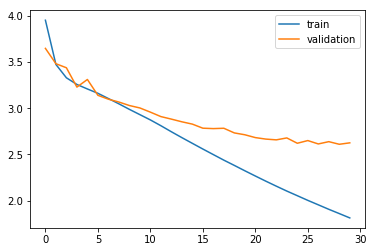

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

load the saved model and make predictions on the unseen data – testX.

In [0]:
model = load_model('model.h1.01_oct_2019')
preds = model.predict_classes(X_test)

These predictions are sequences of integers. We need to convert these integers to their corresponding words. Let’s define a function to do this:

In [0]:
def get_words(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [0]:
preds_text = []
ct = 0
for i in preds:
  ct += 1
  print(ct)
  temp = []
  for j in range(len(i)):
    t = get_words(i[j], eng_tokenizer)
    if j > 0:
      if (t == get_words(i[j-1], eng_tokenizer)) or (t==None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if (t==None):
        temp.append('')
      else:
        temp.append(t)
  preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : np.array(test['raw_text']), 'predicted' : preds_text})

In [82]:
# print 15 rows rando/mly
pred_df.sample(5)

,actual,predicted
3070,highly recommended,highly recommended
3427,in the hands of a powerful spirit a weakness can be transformed into a strength,the setting of the story is can to without
2917,many people dont wish to understand that this movie is not about jesus being tortured but what he went through in his final moments on earth,what people to the film but christ the jesus the hours
6324,simple to use and fantastic,easy to easy and to and
3271,each character had so much to offer to the story,the author is to the


In [93]:
# print 15 rows rando/mly
pred_df.sample(5)

,actual,predicted
1971,i got these nylons for a party in winter,i love this for the
3764,works great,works great
1282,very sturdy,very sturdy
2735,the story is told by greer garason with a great air of dignanty,the story is by the a
4283,i also buy these to refill my larger unit since it is cheaper ordering it this way than individual brushes and rods,i also bought this for i a the with and


Model seems to do great on short sentences whereas it struggle to perform good on long sentences.

I might start performing good if we had larger training data

In [149]:
pred_df.sample(5)

,actual,predicted
4276,this pressure cooker is easy to use and maintains the quality of the end product better than convential cooking,this is easy and to the
1850,there seems to be little common ground which is a shame as the movie should be judged solely on its merits,it is have a of but that should to of
6359,ive had two of these machines,i have this
3136,i found myself holding my breath for long durations of the novel anxiously awaiting what happens next,i was it at in a for book to
2734,the headset has yet to drop bluetooth connection on its own which is a first for all the headsets i8217ve owned and is kind of impressive,the bluetooth has have a the i and the as
